In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
import random
from tqdm.notebook import tqdm
from artemutils.colormaps import get_colormap

In [ ]:
ASSEMBLY_DURATION = 15 # Frames per assembly animation
N_ASSEMBLIES = 20 

# Create a small-world graph
def create_small_world_graph(n_nodes=100, k=20, p=0.12):
    """
    Create a small-world graph using Watts-Strogatz model
    n_nodes: number of nodes
    k: each node is connected to k nearest neighbors
    p: probability of rewiring each edge
    """
    G = nx.watts_strogatz_graph(n_nodes, k, p)
    return G


# Generate random assemblies and ensure connectivity
def generate_assemblies(G, n_assemblies=5, assembly_size=8):
    """
    Generate random assemblies of neurons and ensure each assembly is connected
    by adding necessary edges to the graph
    """
    nodes = list(G.nodes())
    assemblies = []
    
    for _ in range(n_assemblies):
        # Randomly select initial node and grow assembly using BFS
        assembly = []
        start_node = random.choice(nodes)
        available_nodes = set(nodes) - set([start_node])
        assembly.append(start_node)
        
        # Keep adding nearest neighbors until we reach desired size
        while len(assembly) < assembly_size:
            # Find all nodes adjacent to current assembly
            neighbors = set()
            for node in assembly:
                neighbors.update(G.neighbors(node))
            neighbors = neighbors & available_nodes
            
            if neighbors:
                # If there are available neighbors, pick one randomly
                next_node = random.choice(list(neighbors))
            else:
                # If no neighbors available, pick random node and ensure connectivity
                next_node = random.choice(list(available_nodes))
                # Add edge to random node in current assembly
                connect_to = random.choice(assembly)
                G.add_edge(next_node, connect_to)
            
            assembly.append(next_node)
            available_nodes.remove(next_node)
        
        # Ensure assembly is fully connected by adding minimum spanning edges
        assembly_subgraph = G.subgraph(assembly).copy()
        if not nx.is_connected(assembly_subgraph):
            components = list(nx.connected_components(assembly_subgraph))
            for i in range(len(components) - 1):
                # Connect each component to the next one
                node1 = random.choice(list(components[i]))
                node2 = random.choice(list(components[i + 1]))
                G.add_edge(node1, node2)
        
        assemblies.append(assembly)
    
    return assemblies, G


# Create colormap for neural assemblies
import matplotlib.cm as cm
assembly_cmap = get_colormap('coolors-1')  # You can change this to other colormaps like 'plasma', 'magma', 'inferno'

def generate_assembly_colors(n_assemblies):
    """
    Generate unique colors for each assembly using the specified colormap
    """
    colors = []
    for i in range(n_assemblies):
        # Sample evenly spaced colors from the colormap
        color = assembly_cmap(i / (n_assemblies - 1))
        colors.append(color)

    # Randomly shuffle
    np.random.shuffle(colors)
    return colors

# Create initial plot of all assemblies
def create_initial_plot(G, pos, assemblies, assembly_colors, ax):
    """
    Create initial plot with all nodes and edges, returning collections for later updates
    """
    # Initialize all nodes as black
    nodes = nx.draw_networkx_nodes(G, pos, node_color='white',
                                   node_shape='^',
                                 node_size=100, ax=ax)
    

    # Draw background edges with low opacity
    background_edges = nx.draw_networkx_edges(G, pos,
                                            edge_color=(1, 1, 1, 1),
                                            ax=ax)
    
    background_edges.set_alpha(0.25)
    plt.savefig('graph_overlay.png', dpi=200)
    
    nodes.set_alpha(0)
    background_edges.set_alpha(0)


    # Create node color map for each assembly
    node_collections = []
    edge_collections = []
    
    for assembly, color in zip(assemblies, assembly_colors):
        # Draw assembly nodes
        assembly_nodes = nx.draw_networkx_nodes(G, pos,
                                              nodelist=assembly,
                                              node_color=[color],
                                              node_size=100,
                                              node_shape='^',
                                              ax=ax)
        assembly_nodes.set_alpha(0)  # Initially transparent
        node_collections.append(assembly_nodes)
        
        # Draw assembly edges
        assembly_edges = []
        for u, v in G.edges():
            if u in assembly and v in assembly:
                assembly_edges.append((u, v))
        
        if assembly_edges:
            edges = nx.draw_networkx_edges(G, pos,
                                         edgelist=assembly_edges,
                                         edge_color=[color],
                                         ax=ax)
            edges.set_alpha(0)  # Initially transparent
            edge_collections.append(edges)
    

    return node_collections, edge_collections

# Animation update function

def update(frame, node_collections, edge_collections):
    # Calculate current assembly and fade level
    current_assembly = (frame // ASSEMBLY_DURATION) % len(node_collections)
    fade_progress = (frame % ASSEMBLY_DURATION) / ASSEMBLY_DURATION
    
    # Create sine wave fade effect
    fade_level = np.sin(fade_progress * np.pi)
    
    # Reset all assemblies to transparent
    for nodes, edges in zip(node_collections, edge_collections):
        nodes.set_alpha(0)
        edges.set_alpha(0)
    
    # Set current assembly alpha
    node_collections[current_assembly].set_alpha(fade_level)
    edge_collections[current_assembly].set_alpha(fade_level)
    
    return node_collections + edge_collections

# Main function to create and display animation
def animate_neural_assemblies():
    # Create graph and get layout
    G = create_small_world_graph()
    
    # Generate assemblies and get updated graph with assembly connections
    assemblies, G = generate_assemblies(G, N_ASSEMBLIES)
    
    # Get layout after adding assembly connections
    pos = nx.spring_layout(G)
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='black', dpi=200)
    ax.set_facecolor('black')
    plt.axis('off')
    
    # Generate unique colors for each assembly
    assembly_colors = generate_assembly_colors(len(assemblies))
    

    # Create initial plot and get collections
    node_collections, edge_collections = create_initial_plot(G, pos, assemblies, assembly_colors, ax)
    
    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=tqdm(range(N_ASSEMBLIES*ASSEMBLY_DURATION)),
                                 fargs=(node_collections, edge_collections),
                                 interval=30, blit=True)
    
    anim.save('assemblies_flicker.mov', dpi=200)
    #plt.show()
    

  0%|          | 0/300 [00:00<?, ?it/s]

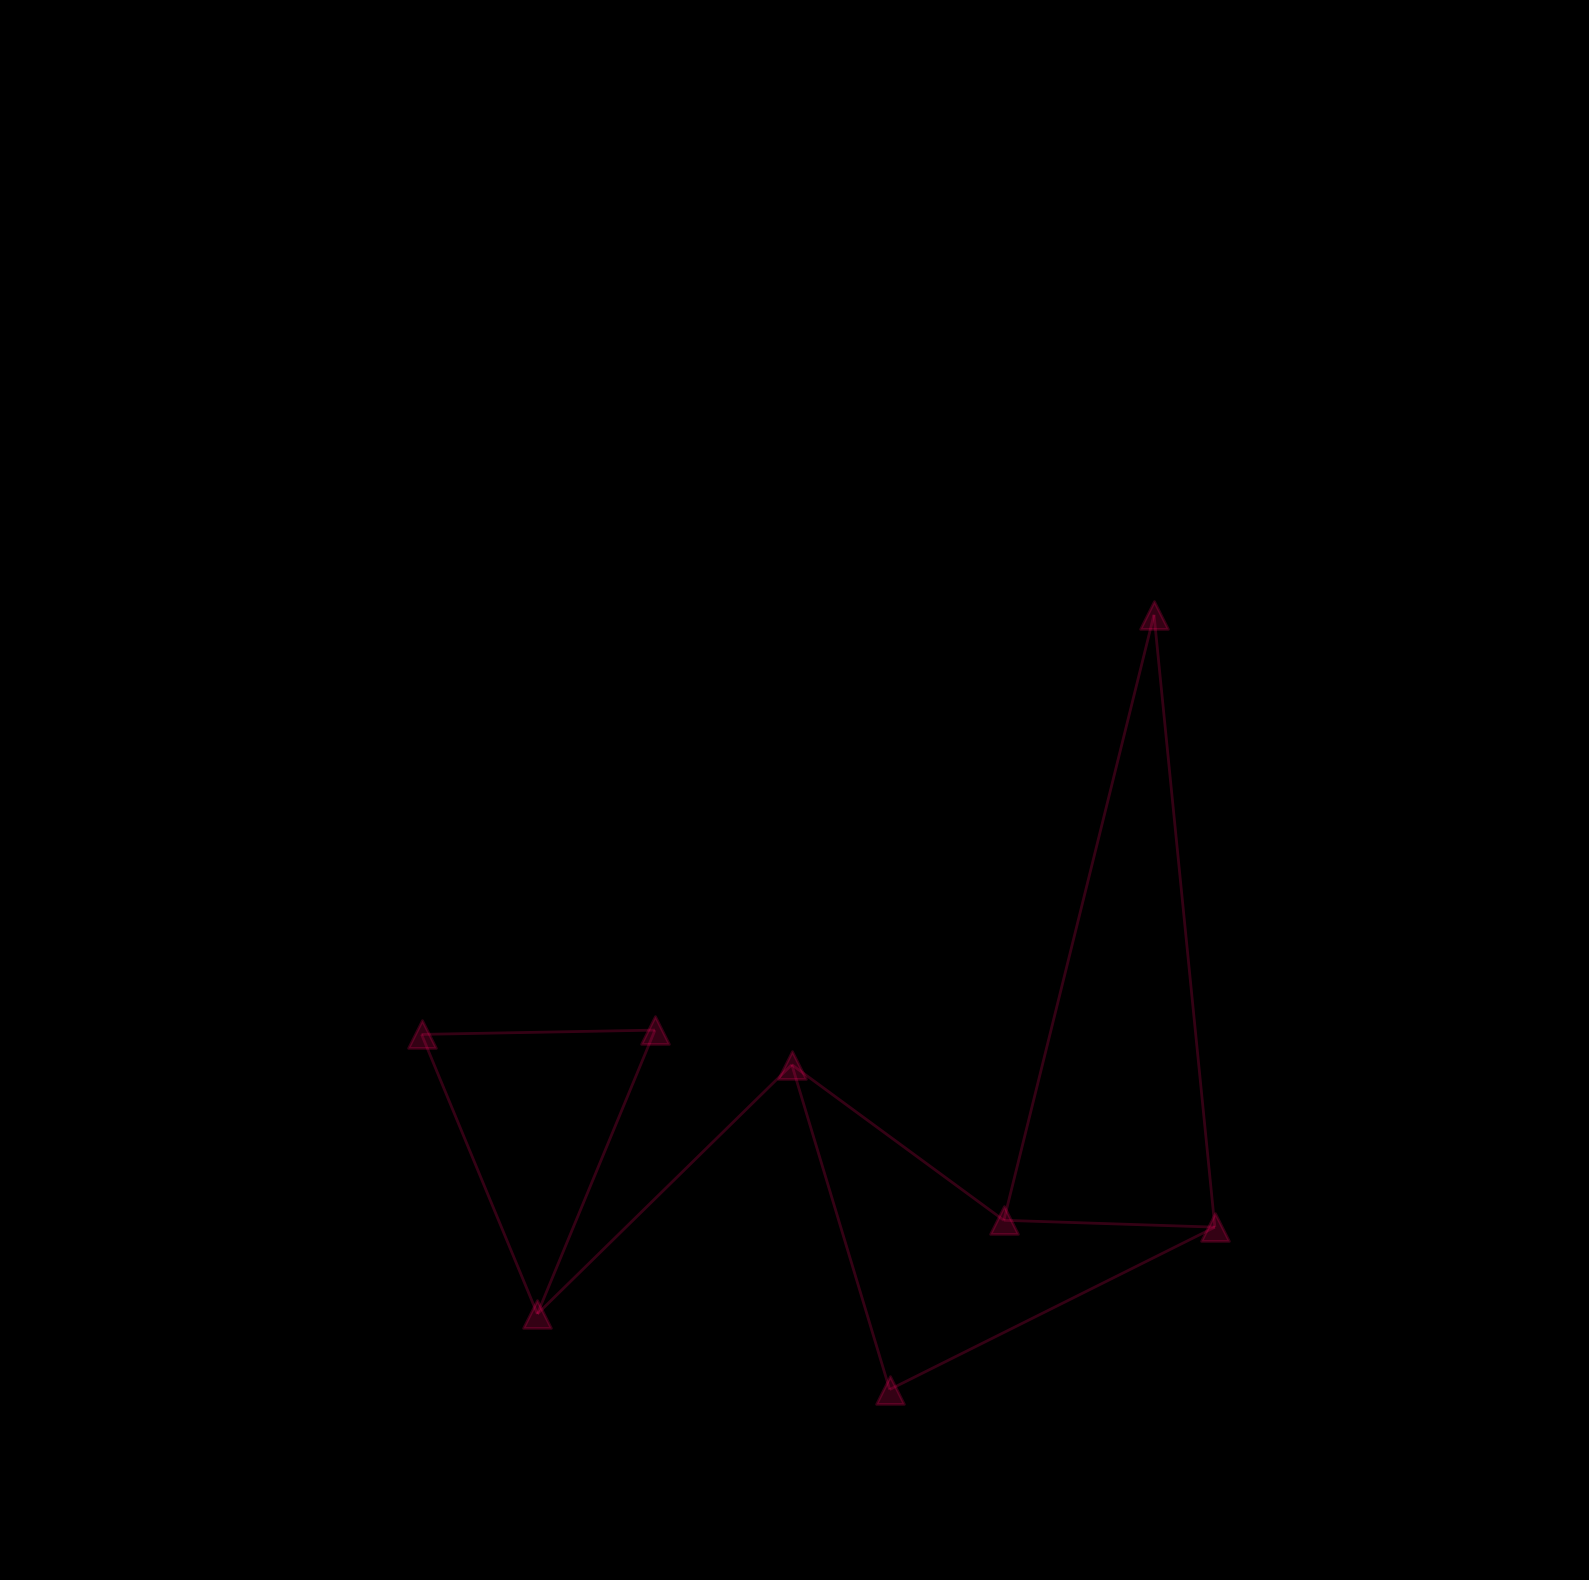

In [38]:
animate_neural_assemblies()